In [4]:
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt 
import shutil
import os 

Husk at det kan være tilfeller der et bilde har flere lesioner, så må lage et skript som tar det til betraktning 

In [2]:
#En idé kan være å tegne alle figurene opp og se om en er inni den andre
#Path til en tekst fil med mange polygons:
path = "/home/heris/data/RAW/YOLO_seg_dataset/train/labels/image_1.3.6.1.4.1.14519.5.2.1.6279.6001.123115230684144889642242761032.txt"
#path = "/home/heris/data/RAW/YOLO_seg_dataset/train/labels/image_1.3.6.1.4.1.14519.5.2.1.6279.6001.137247975605664480994506120006.txt"
#path = "/home/heris/data/RAW/YOLO_seg_dataset/validation/labels/image_1.3.6.1.4.1.14519.5.2.1.6279.6001.160206890829084077691132572335.txt"
#path = "/home/heris/data/RAW/YOLO_seg_dataset/train/labels/image_1.3.6.1.4.1.14519.5.2.1.6279.6001.150637158866736384130158024504.txt"


## Script for getting overlappoing coordinates

[]


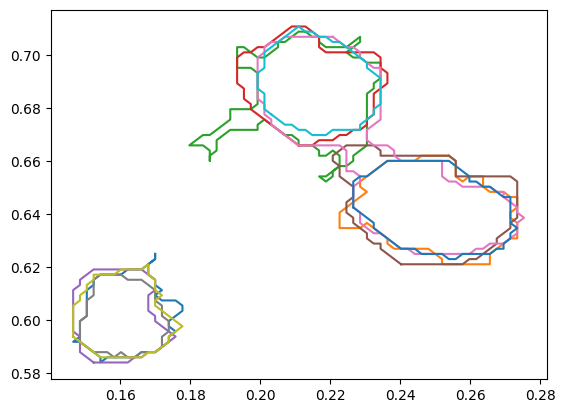

In [6]:
def seperate_polygons(polygons:list): #list of polygons 
    seperate_lesions = []
    seperate_lesions.append(polygons[0])
    seperate_lesions_copy = seperate_lesions.copy()
    for poly in polygons[1:]:
        for i, seperate in enumerate(seperate_lesions):
            intersection = seperate.convex_hull
            if not intersection.intersection(poly.convex_hull).is_empty:
                    break 
            if i == len(seperate_lesions)-1 and intersection.intersection(poly.convex_hull).is_empty:
                seperate_lesions_copy.append(poly)
        seperate_lesions = seperate_lesions_copy.copy()
    return seperate_lesions

def remove_big_and_small_polygons(intersected_polygons: list, min_area: float, max_area: float):
    list_of_indexes = []
    for i, polygon in enumerate(intersected_polygons): 
        if polygon.area < min_area or polygon.area > max_area: 
            list_of_indexes.append(i)
    
    list_of_indexes.reverse() #må reversere fordi hvis noe foran blir fjerna, så endrer indexene til de resterene "poppene" seg. Unngår problemet ved å poppe dem bakfra

    if len(list_of_indexes) > 0: 
        for index in list_of_indexes:
            intersected_polygons.pop(index)
    return intersected_polygons


def overlapPolygon(path:str,is_already_yolo_format:bool,min_area:float,max_area:float, want_plot:bool):
    if is_already_yolo_format:
        skip = 1
    else:
        print(f"Sorry, this path dosen't exist yet. Convert to your files to yolo format and try again")

    with open(path,'r') as file:
        all_polygon_coords = []
        for line in file:
            coord_str = line.split()[skip:] 
            coord = [float(elem) for elem in coord_str]
            all_polygon_coords.append(coord)
   
    if len(all_polygon_coords) < 2:
        single_polygon_tupples = []
        for i in range(len(coord)):
            if i % 2 == 0:
                single_polygon_tupples.append((coord[i],coord[i+1]))
        sinlge_polygon = Polygon(single_polygon_tupples)
        polygon_after_size_check = remove_big_and_small_polygons([sinlge_polygon],min_area,max_area)
        if len(polygon_after_size_check) == 1: 
            xs, ys = polygon_after_size_check[0].exterior.xy
            if want_plot:
                plt.plot(xs,ys,'black')
            return [[xs.tolist(),ys.tolist()]] #Returner samme koordinater i format [[X1,Y1]]
        return []

    polygons = []
    for polygon_coord in all_polygon_coords:
        polygon_tuples = []
        for i in range(len(polygon_coord)): 
            if i % 2 == 0:
                coord_tupple = (polygon_coord[i],polygon_coord[i+1])
                polygon_tuples.append(coord_tupple)
        polygons.append(Polygon(polygon_tuples))

    #Finding the first convex hull for the first polygon for every seperate lesion.
    seperate_lesions = seperate_polygons(polygons=polygons)
    seperate_intersection_of_lesions= [lesions.convex_hull for lesions in seperate_lesions]
    seperate_intersection_of_lesions_copy = seperate_intersection_of_lesions.copy()
    

    #Itterate over the remaining polygons and update the intersection     
    for poly in polygons:
        #Hvis denne intersectionen er tom, har vi mest sannsynligvis to eller flere lesjoner på bildet
        for i, intersections in enumerate(seperate_intersection_of_lesions_copy):
            if not intersections.intersection(poly.convex_hull).is_empty:
                seperate_intersection_of_lesions[i] = intersections.intersection(poly.convex_hull)

    if want_plot:
        for poly in polygons: 
            x, y = poly.exterior.xy
            plt.plot(x,y)

    coords_given_polygon = []

    #for intersection in seperate_intersection_of_lesions: 
    #    x, y = intersection.exterior.xy 
    #    print(f"This is the intersection areas {intersection.area}, and this is the number of points {len(x)}")   
    #    coords_given_polygon.append([x,y])
    #    plt.plot(x,y,'black')

    #Kommentert ut kode over er for kode som ikke har en areal grense 
    for intersection in remove_big_and_small_polygons(seperate_intersection_of_lesions,min_area,max_area): 
        x, y = intersection.exterior.xy 
        coords_given_polygon.append([x.tolist(),y.tolist()])
        if want_plot:
            plt.plot(x,y,'black')

    return coords_given_polygon #Får en liste i en liste seende slik ut [[X1,Y1], [X2,Y2]]


edgemap = overlapPolygon(path=path, is_already_yolo_format=True, min_area=0.9,max_area=1,want_plot=True)
print(edgemap)





## Script for crateing the files in YOLO format 

Først kjøres skriptet i format_for_seg_yolo.ipynb slik at alle tekstfilene allerede er i YOLO format (slipper å endre mye på koden) 
Deretter så lager jeg en tekstfil av samme navn med kun de overlappende regionene.

In [185]:
#Husk at listen som kommer inn har formatet "[[X1,Y1],[X2,Y2],.....]", der Xn,Yn,... er lister med x- eller y- koordinater til n-te polygon
#Får inn "[]" hvis listen er tom, som skjer hvis polygonet/ene ikke oppfylte arealkravet 

input_folder_path = "/home/heris/data/RAW/overlapping/YOLO_seg_pre_dataset_overlapping"
output_folder_path = "/home/heris/data/RAW/overlapping/YOLO_seg_pre_dataset_overlapping_area_req"


def yolo_seg_format_with_overlap(input_folder_path:str, output_folder_path:str, min_area:float, max_area:float, show_plot:bool, is_already_yolo_format:bool):
    if not os.path.exists(output_folder_path):
        os.mkdir(output_folder_path)
    
    for root, _, files in os.walk(input_folder_path):
        for file in files: 
            if file[-3:] == "txt": #remember that we have png files in this folder, and we only want to alter the text files 
                true_polygons_map = overlapPolygon(path = root+"/"+file, is_already_yolo_format=True, min_area=min_area, max_area=max_area,want_plot=show_plot)
                if true_polygons_map != []:
                    shutil.copy(root+"/"+file[0:-3]+"png",output_folder_path) #copying over png file with polygons which passes the area requirements 
                    try:
                        with open(output_folder_path+"/"+file, 'w') as yolofile:
                            for polygon in true_polygons_map: #polygon has the format [Xn,Yn]
                                yolofile.write("0")
                                for i in range(len(polygon[0])): #This correspond to length of Xn. Remember that Xn and Yn has the same length 
                                    if i%2 == 0: 
                                        yolofile.write(f" {polygon[0][i]} {polygon[1][i]}")
                                    elif i == len(polygon[0]):
                                        yolofile.write(f"\n")
                            #print(f"Text has been written to {root}/{file}.")

                    except Exception as e: 
                        print(f"An error occurred: {e}")
    return None

yolo_seg_format_with_overlap(input_folder_path=input_folder_path,output_folder_path=output_folder_path,min_area=0.0005,max_area=0.004,show_plot=False, is_already_yolo_format=True)